In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import pathlib
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from datetime import datetime

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install natsort
import natsort

In [20]:
images_dir_path='/content/drive/MyDrive/mm/Viral_Pneumonia/images'
masks_dir_path='/content/drive/MyDrive/mm/Viral_Pneumonia/masks'

images_dir=os.listdir(images_dir_path)
masks_dir=os.listdir(masks_dir_path)

print("="*32+"\nTotal number of Images : ",len(images_dir))
print("="*32+"\nTotal number of Masks : ",len(masks_dir))

Total number of Images :  1345
Total number of Masks :  1345


Handle duplicate images

In [15]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [21]:
images_dir = natsort.natsorted(images_dir)
masks_dir = natsort.natsorted(masks_dir)

images_path=[]

for i in range(len(images_dir)):
    temp_path=os.path.join(images_dir_path, images_dir[i])
    images_path.append(temp_path)

masks_path=[]

for i in range(len(masks_dir)):
    temp_mask=os.path.join(masks_dir_path, masks_dir[i])
    masks_path.append(temp_mask)

In [22]:
print(images_path[0]+"\n"+masks_path[0])

/content/drive/MyDrive/mm/Viral_Pneumonia/images/Viral Pneumonia-1.png
/content/drive/MyDrive/mm/Viral_Pneumonia/masks/Viral Pneumonia-1.png


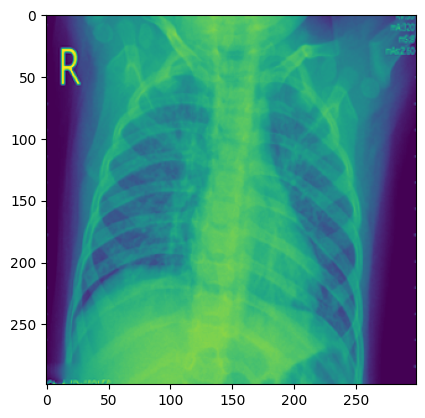

In [23]:
plt.imshow(plt.imread(images_path[0]))

In [24]:
img_row = 256
img_col = 256
img_chan = 3
target_shape = (img_row, img_col, img_chan)
num_imgs=len(images_path)

images=np.zeros((num_imgs, img_row, img_col))
masks=np.zeros_like(images)

In [25]:
def load_imgs_masks(DIR, array):

    for i in range(len(DIR)):
        temp_img=image.load_img(DIR[i], target_size=target_shape)
        img=image.img_to_array(temp_img)
        array[i]=img[:,:,0]/255.0

    array=np.expand_dims(array, axis=3)
    return array

In [26]:
images=load_imgs_masks(images_path, images)
masks=load_imgs_masks(masks_path, masks)

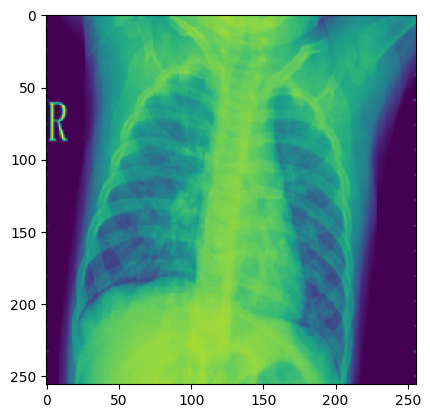

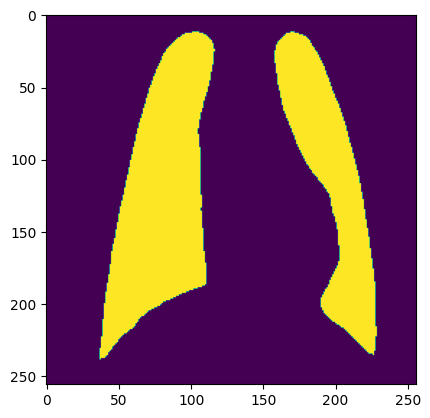

In [29]:
plt.imshow(images[np.random.randint(0,1345)])
plt.show()
plt.imshow(masks[np.random.randint(0,1345)])
plt.show()

In [ ]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.3, random_state=SEED)

# MODEL TRAINING

In [31]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [32]:
def build_model(start_neurons):

    input_layer = Input((256, 256, 1))

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model=Model(inputs=input_layer, outputs=output_layer)

    return model

In [33]:
model=build_model(16)

In [34]:
EPOCHS = 15
model.compile(optimizer=Adam(learning_rate=5*1e-4), loss="binary_crossentropy",
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

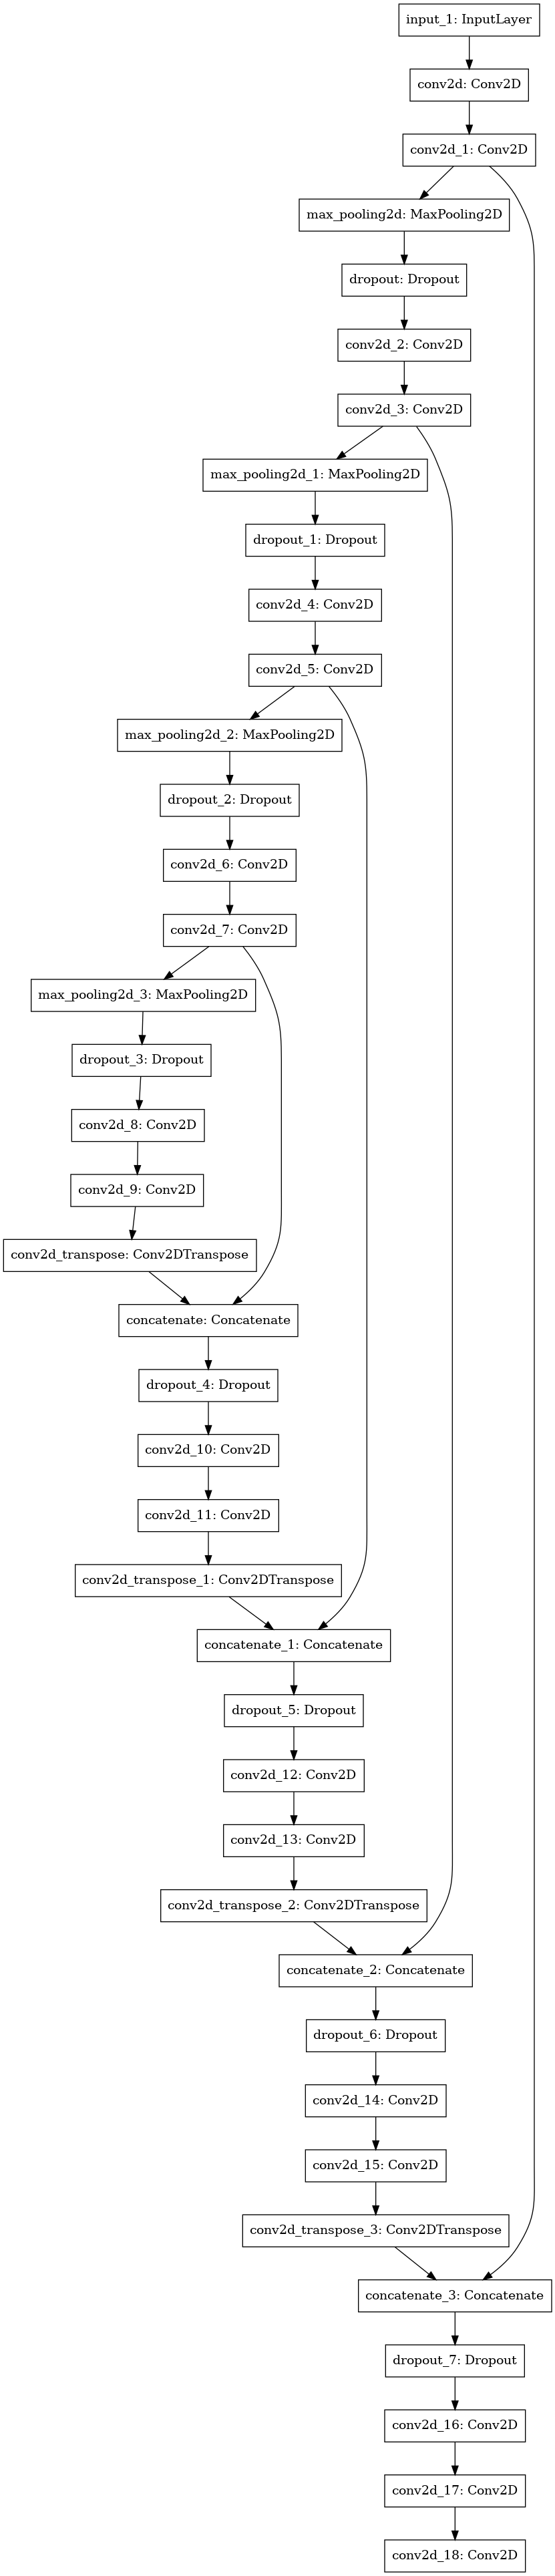

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [35]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', #verbose=1,
                             save_best_only=True, #mode='min',
                             save_weights_only = True)


early = EarlyStopping(monitor="loss",
                      #mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [36]:
curr_time=datetime.now()
print("Starting time : ", datetime.now())
history = model.fit(x = train_images,
                    y = train_masks,
                    validation_data = (test_images, test_masks),
                    epochs = 20,
                    batch_size = 16,
                   callbacks = callbacks_list)
time_now=datetime.now()
print("Ending time : ", time_now)
print("="*40+"Time taken : ", time_now-curr_time)
model.save('my_model.h5')

Starting time :  2024-07-28 17:40:19.073136
Epoch 1/20
59/59 [==============================] - 40s 364ms/step - loss: 0.5597 - dice_coef: 0.2694 - binary_accuracy: 0.7564 - val_loss: 0.4624 - val_dice_coef: 0.3180 - val_binary_accuracy: 0.7678
Epoch 2/20
59/59 [==============================] - 12s 200ms/step - loss: 0.3720 - dice_coef: 0.4299 - binary_accuracy: 0.7866 - val_loss: 0.4082 - val_dice_coef: 0.4587 - val_binary_accuracy: 0.8227
Epoch 3/20
59/59 [==============================] - 12s 202ms/step - loss: 0.2162 - dice_coef: 0.7253 - binary_accuracy: 0.9176 - val_loss: 0.1807 - val_dice_coef: 0.7400 - val_binary_accuracy: 0.9290
Epoch 4/20
59/59 [==============================] - 12s 205ms/step - loss: 0.1335 - dice_coef: 0.8334 - binary_accuracy: 0.9485 - val_loss: 0.1871 - val_dice_coef: 0.7221 - val_binary_accuracy: 0.9269
Epoch 5/20
59/59 [==============================] - 12s 207ms/step - loss: 0.1048 - dice_coef: 0.8682 - binary_accuracy: 0.9589 - val_loss: 0.1469 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
model.evaluate(test_images, test_masks)

13/13 [==============================] - 9s 355ms/step - loss: 0.0705 - dice_coef: 0.9207 - binary_accuracy: 0.9727


[0.07046186923980713, 0.920730471611023, 0.9727141261100769]

1/1 [==============================] - 1s 1s/step


0.8918274636801151

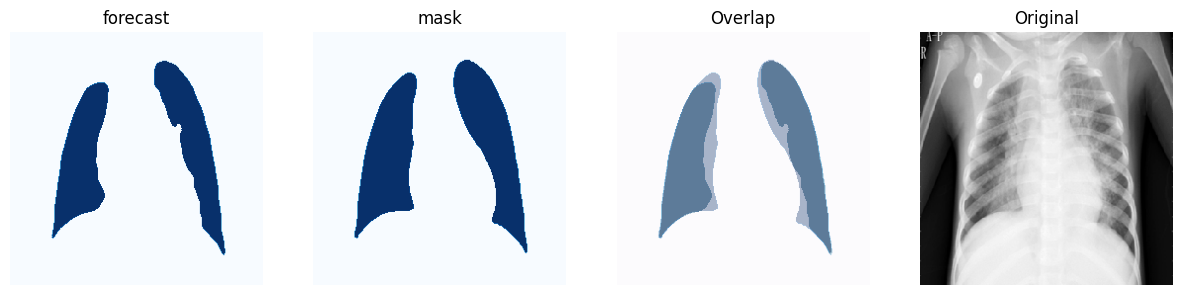

In [38]:
def test_on_image(model, img_array, img_num, img_side_size = 256):

    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))

    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("forecast")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(test_masks[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("mask");
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(test_masks[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("Overlap")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")

    return pred

def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

IMG_NUM = 3 #Melhor img_num 12 (0.98) Pior img_num 10 (0.9)
prediction = test_on_image(model, img_array = test_images, img_num = IMG_NUM, img_side_size = 256)
dice_coef_test(y_true = test_masks[IMG_NUM], y_pred = prediction)

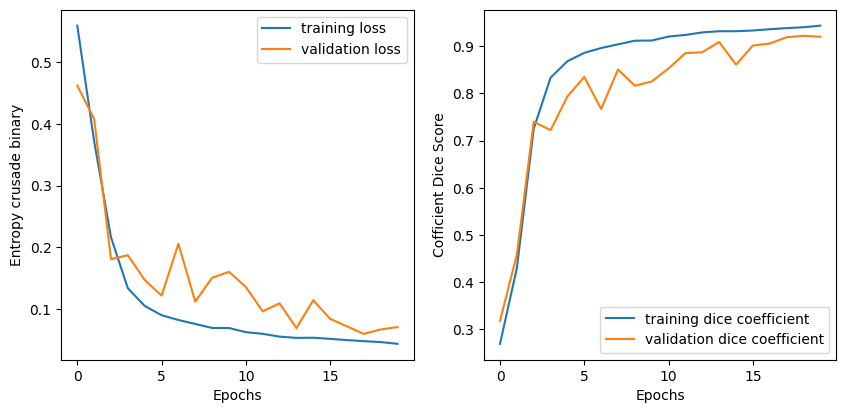

In [39]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Entropy crusade binary")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Cofficient Dice Score")

get_metrics(history = history)

In [ ]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_binary_accuracy'])